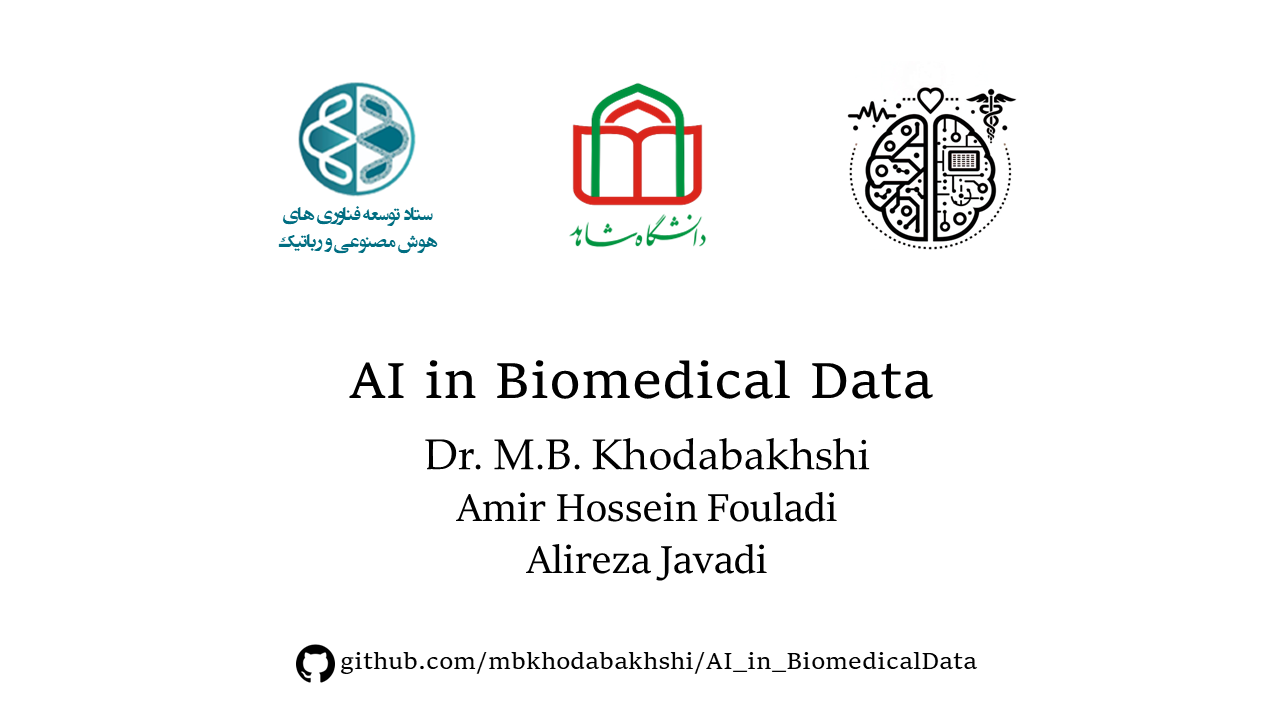

https://github.com/mbkhodabakhshi/AI_in_BiomedicalData

----------------

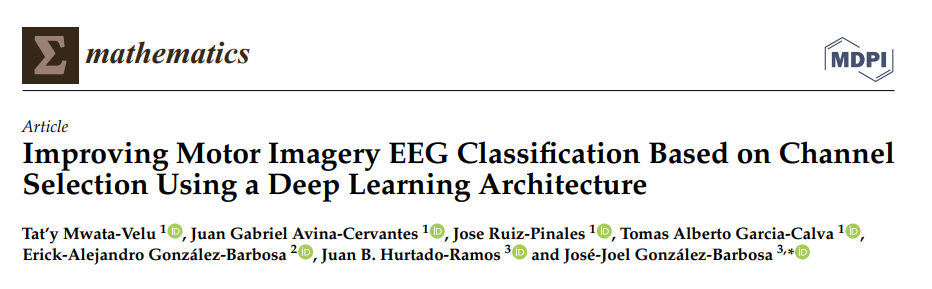

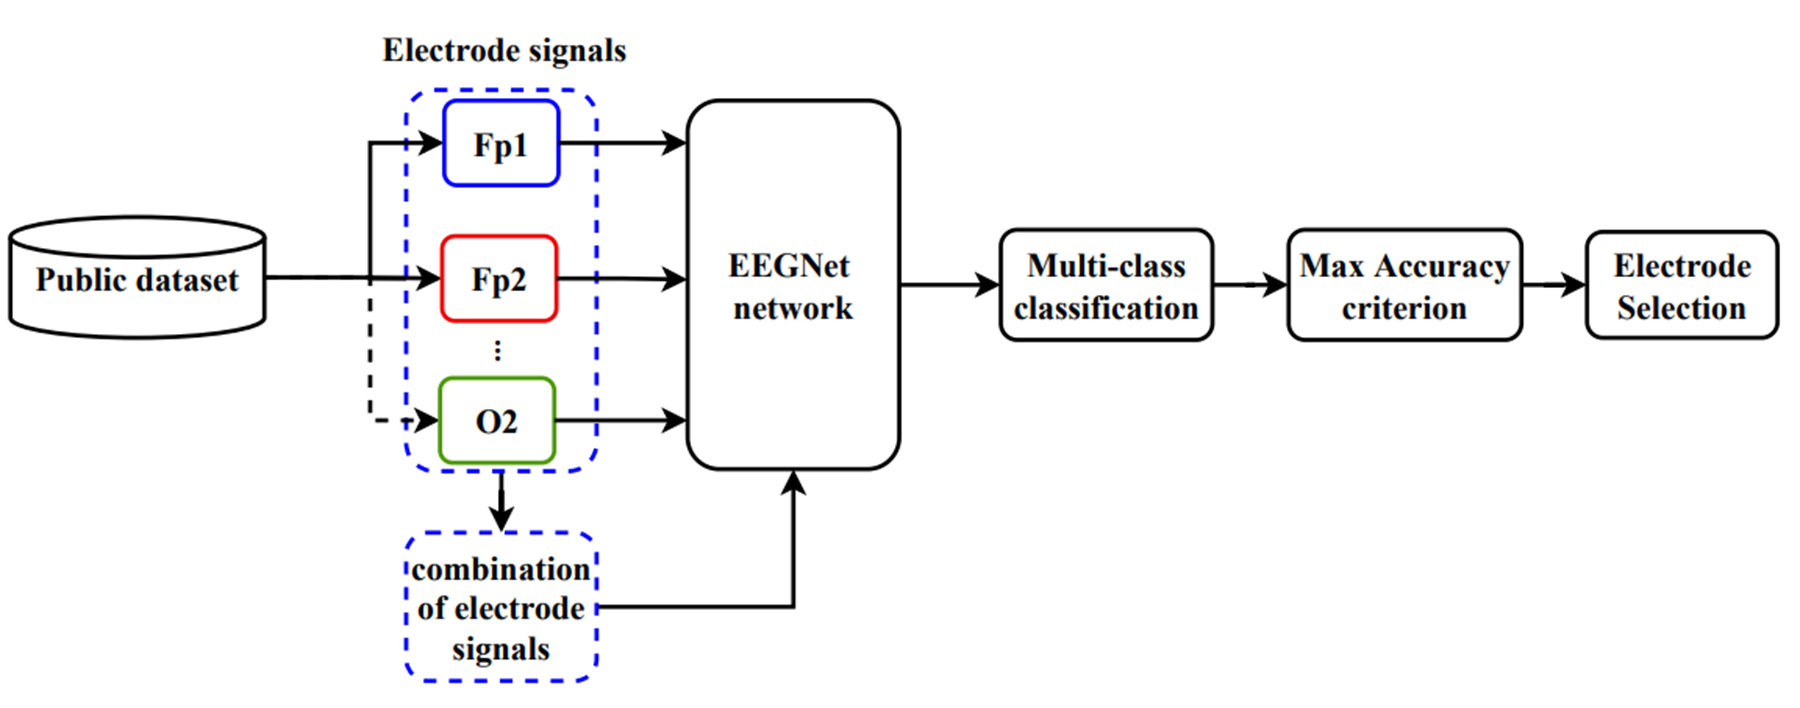

https://doi.org/10.3390/math10132302

-------------------------

# Dataset

https://doi.org/10.1038/sdata.2018.211

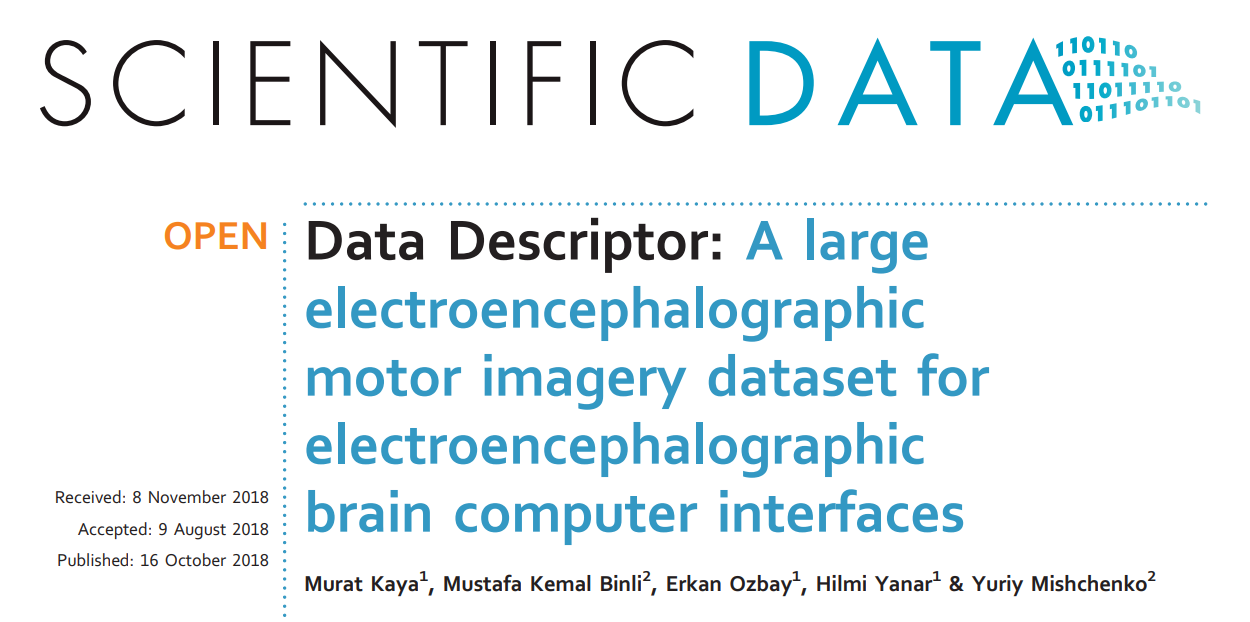

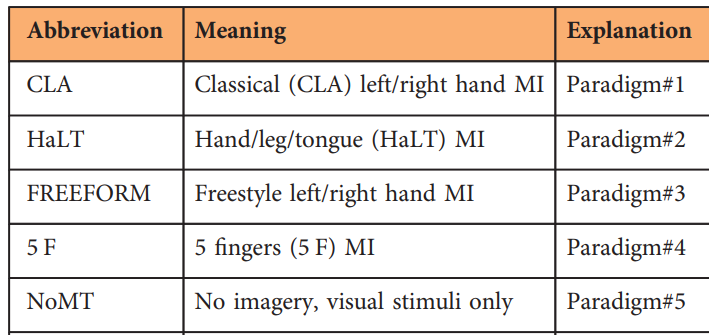

-------------------------------------------

[Dataset Link](https://springernature.figshare.com/collections/A_large_electroencephalographic_motor_imagery_dataset_for_electroencephalographic_brain_computer_interfaces/3917698)


-----------------

# Preprocessing

## load data

https://pytorch.org

In [1]:
import os
import scipy.io
import numpy as np
import torch

fr_samp= 1000
path= r'./data/'
file_list= os.listdir(path)

data= torch.tensor([])
mark= torch.tensor([])
data_list= []
marker_list= []
for file_name in file_list:
    if file_name.endswith('.mat'):
        file_path= os.path.join(path, file_name)
        mat_data= scipy.io.loadmat(file_path)
        data_array= np.array(mat_data['o']['data'][0, 0])
        marker_array= np.array(mat_data['o']['marker'][0, 0])
        torch_data= torch.from_numpy(data_array)
        torch_marker= torch.from_numpy(marker_array)
        data= torch.cat((data, torch_data), dim=0)
        mark= torch.cat((mark, torch_marker), dim=0)
        
mark= mark[:,0]
print(mark.shape)
print(data.shape)

torch.Size([2162600])
torch.Size([2162600, 22])


## finding the first sample of each trial

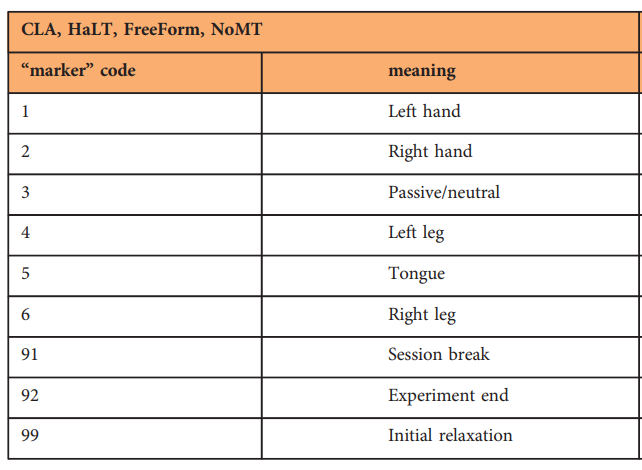

In [2]:
pr= 0
cl_1_ind= []
cl_2_ind= []
cl_3_ind= []
cl_4_ind= []
cl_5_ind= []

for i in range(mark.shape[0]):
    nx= mark[i]
    if pr != nx:
        if nx== 1:
            cl_1_ind.append(i)
        elif nx== 2:
            cl_2_ind.append(i)
        elif nx== 4:
            cl_3_ind.append(i)
        elif nx== 5:
            cl_4_ind.append(i)
        elif nx== 6:
            cl_5_ind.append(i)
    pr= nx
        
print(len(cl_1_ind), len(cl_2_ind), len(cl_3_ind), len(cl_4_ind), len(cl_5_ind))

464 480 492 496 469


## separation of trials

In [3]:
def trial_sepration(data, mark_indx, length= fr_samp):
    output= torch.tensor([])
    for index in mark_indx:
        output= torch.cat((output, data[index: index+length, :].unsqueeze(0)), dim= 0)
    return output

In [4]:
def data_mark_maker(cl_ind, new_mark, dataset= data):
    cls_data= trial_sepration(dataset, cl_ind)
    cls_mark= torch.full((cls_data.shape), new_mark, dtype=torch.long)[:,0,0]
    return cls_data, cls_mark

In [5]:
cls_1_data, cls_1_mark= data_mark_maker(cl_1_ind, 0)
cls_2_data, cls_2_mark= data_mark_maker(cl_2_ind, 1)
cls_3_data, cls_3_mark= data_mark_maker(cl_3_ind, 2)
cls_4_data, cls_4_mark= data_mark_maker(cl_4_ind, 3)
cls_5_data, cls_5_mark= data_mark_maker(cl_5_ind, 4)

In [6]:
del cl_1_ind, cl_2_ind, cl_3_ind, cl_4_ind, cl_5_ind

## concat cls

In [7]:
data= torch.cat((cls_1_data, cls_2_data, cls_3_data, cls_4_data, cls_5_data), dim= 0)
mark= torch.cat((cls_1_mark, cls_2_mark, cls_3_mark, cls_4_mark, cls_5_mark), dim= 0)

In [8]:
del cls_1_data, cls_2_data, cls_4_data, cls_5_data, cls_3_data
del cls_1_mark, cls_2_mark, cls_4_mark, cls_5_mark, cls_3_mark

In [9]:
num_sample= mark.shape[0]
rnd_perm= torch.randperm(num_sample)

data= data[rnd_perm].float()
mark= mark[rnd_perm].long()

## save data

In [10]:
data= data.unsqueeze(1).permute(0,1,3,2)
torch.save(data, 'data.pth')
torch.save(mark, 'mark.pth')

print(data.shape)
print(mark.shape)

torch.Size([2401, 1, 22, 1000])
torch.Size([2401])


-----------------------

## split

In [11]:
from sklearn.model_selection import train_test_split
train_ratio= 0.8

x_train, x_test, y_train, y_test= train_test_split(data, mark, train_size= train_ratio)
x_train, x_valid, y_train, y_valid= train_test_split(x_train, y_train, train_size= train_ratio)
print('train: ', x_train.shape, y_train.shape)
print('valid: ', x_valid.shape, y_valid.shape)
print('test: ', x_test.shape, y_test.shape)

train:  torch.Size([1536, 1, 22, 1000]) torch.Size([1536])
valid:  torch.Size([384, 1, 22, 1000]) torch.Size([384])
test:  torch.Size([481, 1, 22, 1000]) torch.Size([481])


## dataloader

In [12]:
from torch.utils.data import DataLoader, TensorDataset
train_batch_size= 256
valid_batch_size= 256

train_dataset= TensorDataset(x_train, y_train)
valid_dataset= TensorDataset(x_valid, y_valid)
test_dataset= TensorDataset(x_test, y_test)

train_loader= DataLoader(train_dataset, batch_size= train_batch_size, shuffle= True)
valid_loader= DataLoader(valid_dataset, batch_size= valid_batch_size, shuffle= False)
test_loader= DataLoader(test_dataset, batch_size= valid_batch_size, shuffle= False)

print("train batch size:",train_loader.batch_size, ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size, ", num of batch:", len(valid_loader))
print("test batch size:",test_loader.batch_size, ", num of batch:", len(test_loader))

train batch size: 256 , num of batch: 6
valid batch size: 256 , num of batch: 2
test batch size: 256 , num of batch: 2


In [13]:
x,y= next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([256, 1, 22, 1000]) torch.Size([256])


--------------------------

# Model

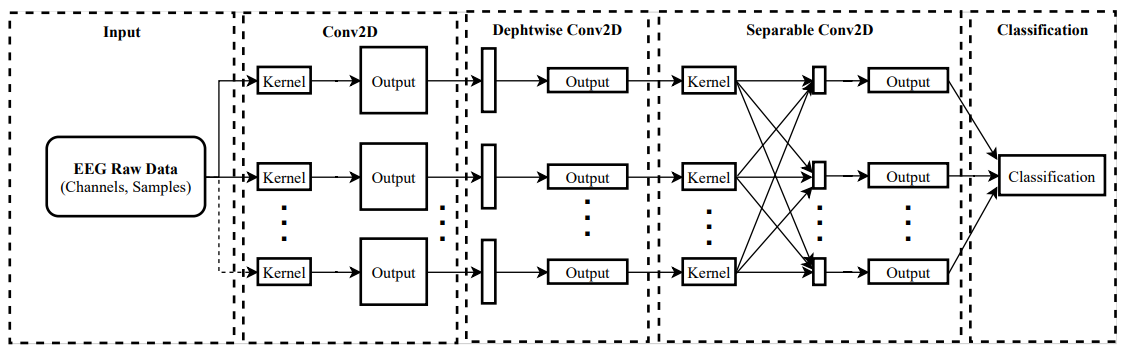

## hyperparameters

In [14]:
num_class= 5
num_input= 1
channel= 22
signal_length= 1000
fs= 1000

F1= 8
D= 3
F2= D*F1

kernel_size_1= (1,round(fs/2)) 
kernel_size_2= (channel, 1)
kernel_size_3= (1, round(fs/8))
kernel_size_4= (1, 1)

kernel_avgpool_1= (1,4)
kernel_avgpool_2= (1,8)
dropout_rate= 0.2

ks0= int(round((kernel_size_1[0]-1)/2))
ks1= int(round((kernel_size_1[1]-1)/2))
kernel_padding_1= (ks0, ks1-1)
ks0= int(round((kernel_size_3[0]-1)/2))
ks1= int(round((kernel_size_3[1]-1)/2))
kernel_padding_3= (ks0, ks1)

## defining the base class

In [15]:
import torch.nn as nn

class EEGNet(nn.Module): 
    def __init__(self):
        super().__init__()
        # layer 1
        self.conv2d= nn.Conv2d(num_input, F1, kernel_size_1, padding=kernel_padding_1)
        self.Batch_normalization_1= nn.BatchNorm2d(F1)
        # layer 2
        self.Depthwise_conv2D= nn.Conv2d(F1, D*F1, kernel_size_2, groups= F1)
        self.Batch_normalization_2= nn.BatchNorm2d(D*F1)
        self.Elu= nn.ELU()
        self.Average_pooling2D_1= nn.AvgPool2d(kernel_avgpool_1)
        self.Dropout= nn.Dropout2d(dropout_rate)
        # layer 3
        self.Separable_conv2D_depth= nn.Conv2d(D*F1, D*F1, kernel_size_3,
                                               padding= kernel_padding_3, groups= D*F1)
        self.Separable_conv2D_point= nn.Conv2d(D*F1, F2, kernel_size_4)
        self.Batch_normalization_3= nn.BatchNorm2d(F2)
        self.Average_pooling2D_2= nn.AvgPool2d(kernel_avgpool_2)
        # layer 4
        self.Flatten= nn.Flatten()
        self.Dense= nn.Linear(F2* round(signal_length/32), num_class)
        self.Softmax= nn.Softmax(dim= 1)
        
        
    def forward(self, x):
        # layer 1
        y= self.Batch_normalization_1(self.conv2d(x))
        # layer 2
        y= self.Batch_normalization_2(self.Depthwise_conv2D(y))
        y= self.Elu(y)
        y= self.Dropout(self.Average_pooling2D_1(y))
        # layer 3
        y= self.Separable_conv2D_depth(y)
        y= self.Batch_normalization_3(self.Separable_conv2D_point(y))
        y= self.Elu(y)
        y= self.Dropout(self.Average_pooling2D_2(y))
        # layer 4
        y= self.Flatten(y)
        y= self.Dense(y)
        y= self.Softmax(y)
        
        return y

In [16]:
import torch.optim as optim

model= EEGNet()
eta= 0.01
loss_fn= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr= eta)

# Train

## one epoch

In [17]:
from torchmetrics import Accuracy

def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train= AverageMeter()
    acc_train= Accuracy(task= "multiclass", num_classes= num_class)
    
    for i, (inputs, targets) in enumerate(train_loader):
        outputs= model(inputs)
        loss= loss_fn(outputs, targets)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
        
    return model, loss_train.avg, acc_train.compute().item()

In [18]:
from torchmetrics import F1Score

def test_one_epoch(model, test_loader, loss_fn, optimizer):
    model.eval()
    loss_test= AverageMeter()
    acc_test= Accuracy(task= "multiclass", num_classes= num_class)
    f1_test= F1Score(task= "multiclass", num_classes= num_class)

    for i, (inputs, targets) in enumerate(test_loader):
        outputs= model(inputs)
        loss= loss_fn(outputs, targets)
        loss_test.update(loss.item())
        acc_test(outputs, targets.int())
        f1_test(outputs, targets.int())
        
    return model, loss_test.avg, acc_test.compute().item(), f1_test.compute().item()

## utils

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## training

In [20]:
num_epochs= 100

loss_train_hist, acc_train_hist= [], []
loss_valid_hist, acc_valid_hist= [], []
loss_test_hist, acc_test_hist= [], []


for epoch in range(num_epochs):
    model, loss_train, acc_train= train_one_epoch(model, train_loader, loss_fn, optimizer)
    model, loss_valid, acc_valid, _= test_one_epoch(model, valid_loader, loss_fn, optimizer)
    model, loss_test, acc_test, f1score= test_one_epoch(model, test_loader, loss_fn, optimizer)
  
    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)
    loss_valid_hist.append(loss_valid)
    acc_valid_hist.append(acc_valid)
    loss_test_hist.append(loss_test)
    acc_test_hist.append(acc_test)
    
    if (epoch%5== 0):
        print(f'epoch {epoch}:')
        print(f' Loss= {loss_train:.4}, Accuracy= {int(acc_train*100)}%')
        print(f' Loss= {loss_valid:.4}, Accuracy= {int(acc_valid*100)}%')
        print(f' Loss= {loss_test:.4}, Accuracy= {int(acc_test*100)}%')
        print(f' f1 score= {(f1score*100):.4}\n')

epoch 0:
 Loss= 1.596, Accuracy= 26%
 Loss= 1.606, Accuracy= 20%
 Loss= 1.599, Accuracy= 30%
 f1 score= 30.15

epoch 5:
 Loss= 1.482, Accuracy= 48%
 Loss= 1.489, Accuracy= 51%
 Loss= 1.473, Accuracy= 53%
 f1 score= 53.22

epoch 10:
 Loss= 1.384, Accuracy= 58%
 Loss= 1.363, Accuracy= 63%
 Loss= 1.362, Accuracy= 63%
 f1 score= 63.2

epoch 15:
 Loss= 1.318, Accuracy= 63%
 Loss= 1.295, Accuracy= 70%
 Loss= 1.303, Accuracy= 66%
 f1 score= 66.11

epoch 20:
 Loss= 1.273, Accuracy= 68%
 Loss= 1.243, Accuracy= 73%
 Loss= 1.262, Accuracy= 69%
 f1 score= 69.85

epoch 25:
 Loss= 1.229, Accuracy= 73%
 Loss= 1.205, Accuracy= 76%
 Loss= 1.224, Accuracy= 72%
 f1 score= 72.97

epoch 30:
 Loss= 1.188, Accuracy= 76%
 Loss= 1.174, Accuracy= 79%
 Loss= 1.194, Accuracy= 75%
 f1 score= 75.47

epoch 35:
 Loss= 1.16, Accuracy= 79%
 Loss= 1.15, Accuracy= 81%
 Loss= 1.164, Accuracy= 77%
 f1 score= 77.55

epoch 40:
 Loss= 1.13, Accuracy= 81%
 Loss= 1.136, Accuracy= 80%
 Loss= 1.142, Accuracy= 80%
 f1 score= 80.04

# Learning Curve

## loss

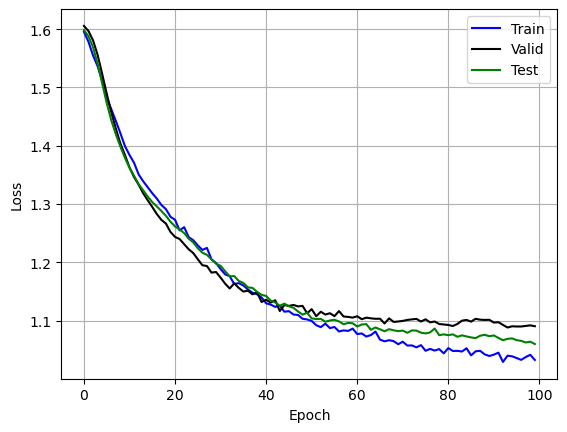

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), loss_train_hist, 'b-', label= 'Train')
plt.plot(range(num_epochs), loss_valid_hist, 'k-', label= 'Valid')
plt.plot(range(num_epochs), loss_test_hist, 'g-', label= 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

## accuracy

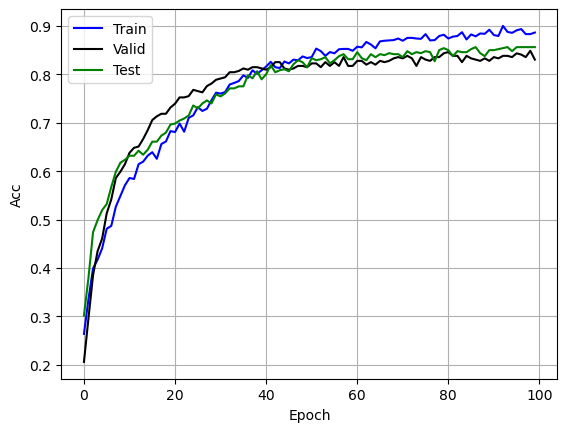

In [22]:
plt.plot(range(num_epochs), acc_train_hist, 'b-', label= 'Train')
plt.plot(range(num_epochs), acc_valid_hist, 'k-', label= 'Valid')
plt.plot(range(num_epochs), acc_test_hist, 'g-', label= 'Test')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()